In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


In [2]:
# Code https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Root directory for dataset
dataroot = "/home/dhagash/MS-GE-03/CudaVision/assignment-7/data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 256

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

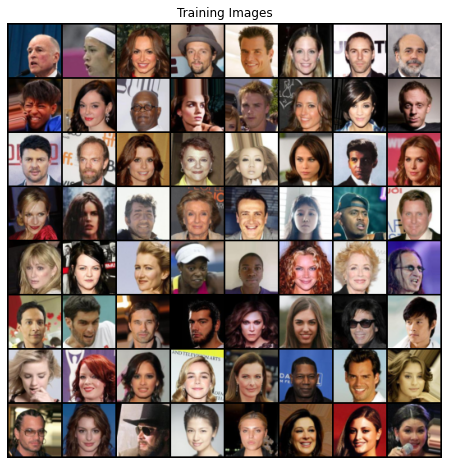

In [3]:
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.main = nn.Sequential(
                                  nn.ConvTranspose2d(in_channels=nz,out_channels=ngf*16,kernel_size=4,stride=1,padding=0,bias=False),
                                  nn.BatchNorm2d(ngf*16),
                                  nn.ReLU(inplace=True),
                                  nn.ConvTranspose2d(in_channels=ngf*16, out_channels=ngf*8, kernel_size=4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(ngf*8),
                                  nn.ReLU(inplace=True),
                                  nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(ngf*4),
                                  nn.ReLU(inplace=True),
                                  nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(ngf*2),
                                  nn.ReLU(inplace=True),
                                  nn.ConvTranspose2d(in_channels=ngf*2, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
                                  nn.Tanh(),
                                  )
    def forward(self,x):
        out =  self.main(x)
        return out


In [6]:
class Descriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.main = nn.Sequential(
           
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self,x):
        out = self.main(x)

        return out

In [7]:
class Trainer:
    """
    Class for initializing GAN and training it
    """

    def __init__(self,writer):
        """ Initialzer """
        
        self.writer = writer

        self.netG = Generator().to(device).apply(weights_init)
        self.netD = Descriminator().to(device).apply(weights_init)

        self.real_label = 1.


        self.fake_label = 0.
        self.criterion = nn.BCELoss()
        

        self.optimizerD = optim.Adam(self.netD.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=lr, betas=(beta1, 0.999)) 

        return

    def train_one_step(self, imgs):
        """ Training both models for one optimization step """

        self.netG.train()
        self.netD.train()
        b_size = imgs.shape[0]
        latent = torch.randn(b_size, nz, 1, 1, device=device)

        # Sample from the latent distribution

        # ==== Training Discriminator ====
        self.optimizerD.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.netD(imgs).view(-1)
        
        label = torch.full((b_size,), self.real_label, dtype=torch.float, device=device)
        # Compute the loss function
        d_loss_real = self.criterion(prediction_real,label)
        d_loss_real.backward()
        
        # Generating fake samples with the generator
        fake_samples = self.netG(latent)
        label.fill_(self.fake_label)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.netD(
            fake_samples.detach()).view(-1)  # why detach?
        # Compute the loss function
        d_loss_fake = self.criterion(prediction_fake_d,label)
        d_loss_fake.backward()
        torch.nn.utils.clip_grad_norm_(self.netD.parameters(), 3.0)


        # optimization step
        self.optimizerD.step()

        # === Train the generator ===
        self.optimizerG.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.netD(fake_samples).view(-1)
        label.fill_(self.real_label)
        # Compute the loss function
        g_loss = self.criterion(prediction_fake_g,label)
        g_loss.backward()
        # optimization step
        self.optimizerG.step()

        return d_loss_real + d_loss_fake, g_loss

    @torch.no_grad()
    def generate(self):
        """ Generating a bunch of images using current state of generator """
        self.netG.eval()
        latent = fixed_noise = torch.randn(64, nz, 1, 1, device=device)
        samples = self.netG(latent)
        return samples.detach().cpu()

    def train(self, data_loader, N_iters=15, init_step=0):
        """ Training the models for several iterations """

        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0

        iter_ = 0
        for i in range(N_iters):
            for j,data in enumerate(data_loader,0):
                
                real_samples = data[0].to(device)
                d_loss, g_loss = self.train_one_step(imgs=real_samples)

                # updating progress bar
                progress_bar.set_description(
                    f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")

                # adding stuff to tensorboard
                if (j%50 == 0):
                    self.writer.add_scalar(
                        f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                    self.writer.add_scalar(
                        f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                    self.writer.add_scalars(f'Comb_Loss/Losses', {
                        'Discriminator': d_loss.item(),
                        'Generator':  g_loss.item()
                    }, iter_)
                if(iter_ % 500 == 0):
                    imgs = self.generate()
                    grid = vutils.make_grid(imgs, padding=2, normalize=True)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(
                        os.getcwd(), "imgs", "training", f"imgs_256_{iter_}.png"))

                iter_ = iter_ + 1

        return

In [8]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan_256")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

In [9]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [10]:
trainer = Trainer(writer=writer)

In [11]:
trainer.train(data_loader=dataloader)

Ep 15 Iter 23744: D_Loss=0.33472, G_Loss=7.46519):   0%|          | 0/15 [32:55<?, ?it/s] 


In [20]:
import imageio
images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_256_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(
    x.split("_")[1].split(".")[0]))


In [21]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress_256.gif"), images)


In [22]:
imgs = trainer.generate()
grid = torchvision.utils.make_grid(imgs, nrow=8)

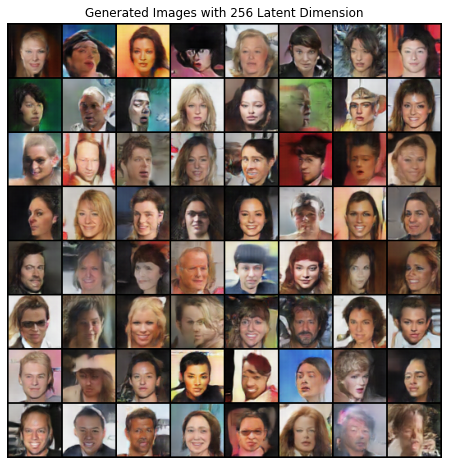

In [27]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images with 256 Latent Dimension")
plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))


**Remarks**

- Better stability in training with increase in latent dimension size
- Tried changing architecture and learning rates but the desired loss of Descriminator 0.5 was not achieved
- Training for longer time resulted in Descriminator and Generator diverging(Any FIX)